## Searching for related features using Lydia's data frame (with cell type & location features)

In [1]:
from allensdk.core.cell_types_cache import CellTypesCache

# !! update this path so that it points to your external hard drive !!
ctc = CellTypesCache(manifest_file='D:/cell_types/manifest.json')

# get metadata for all the cells
cells_sdk = ctc.get_cells()
print "There are %d cells in the cache" % len(cells_sdk)

There are 248 cells in the cache


In [2]:
import re

# helper function to break up structure into regions and layer
def split_region_layer(cell) :
    a = cell['structure']['acronym']
    si = 0
    for idx,x in enumerate(a) :
        if x.isdigit() :
            si = idx
            break
    return {'region': a[:si], 'layer': a[si:]}
    
print split_region_layer(cells_sdk[0])

{'region': u'VISp', 'layer': u'4'}


In [3]:
# helper function to get the mouse line
def transgenic_drivers( cell ) :
    tlist = cell['donor']['transgenic_lines']
    dlist = [str(x['name']) for x in tlist if x['transgenic_line_type_name'] == 'driver' ]
    return {'mouse_line':";".join( dlist )}

print transgenic_drivers(cells_sdk[0])

{'mouse_line': 'Sst-IRES-Cre'}


In [4]:
# create temporary record dictionary with the metadata we want to keep

index_key = ['id']
sample_keys = ['mouse_line','region','layer','hemisphere']
annotation_keys = ['dendrite_type','apical']
modality_keys = ['has_morphology', 'has_reconstruction']

def filter_list(keys,exclude_keys) : 
    return [ x for x in keys if x not in exclude_keys ]

def clean_keys(keys) :
    return [ str(x) for x in keys ]

# cell soma location keys
csl_keys = cells_sdk[0]['cell_soma_locations'][0].keys()
exclude_csl_keys = ['id','specimen_id']
csl_keys = clean_keys(filter_list( csl_keys, exclude_csl_keys))

# ephys feature keys
ef_keys = cells_sdk[0]['ephys_features'][0].keys()
exclude_ef_keys = ['id','specimen_id']
ef_keys = clean_keys(filter_list( ef_keys, exclude_ef_keys ))

# neuron reconstruction keys
c = [ x for x in cells_sdk if x['has_reconstruction']][0]
nr_keys = c['neuron_reconstructions'][0].keys()
exclude_nr_keys = ['id','specimen_id','tags']
nr_keys = clean_keys(filter_list( nr_keys, exclude_nr_keys ))

columns = index_key + sample_keys + annotation_keys + modality_keys + csl_keys + ef_keys + nr_keys

In [5]:
def filter_dictonary_by_keys( d, k ) :
     return { x: d[x] for x in k }
    
def fetch_data( c ) :
    d = filter_dictonary_by_keys( c, (index_key + annotation_keys + modality_keys + ['hemisphere']) )
    d.update( split_region_layer(c) )
    d.update( transgenic_drivers(c) )
    d.update( filter_dictonary_by_keys( c['cell_soma_locations'][0], csl_keys) )
    d.update( filter_dictonary_by_keys( c['ephys_features'][0], ef_keys) )
    if c['has_reconstruction'] :
        d.update( filter_dictonary_by_keys( c['neuron_reconstructions'][0], nr_keys ) )
    return d

cells_records = [fetch_data(c) for c in cells_sdk]
    
print cells_records[0]['mouse_line']

Sst-IRES-Cre


In [6]:
# create pandas dataframe
import pandas as pd

cells_df = pd.DataFrame.from_records( cells_records, index = 'id', columns=columns )
cells_df.head()

,mouse_line,region,layer,hemisphere,dendrite_type,apical,has_morphology,has_reconstruction,normalized_depth,reference_space_id,...,number_stems,number_branches,average_fragmentation,average_contraction,average_bifurcation_angle_remote,hausdorff_dimension,total_surface,max_branch_order,soma_surface,overall_height
id,,,,,,,,,,,,,,,,,,,,,
324257146,Sst-IRES-Cre,VISp,4,left,aspiny,NA,True,True,0.410398,9,...,6,30,34.2333,0.776329,77.4101,1.12107,1416.64,6,111.175,215.758
469622566,Scnn1a-Tg3-Cre,VISp,5,right,spiny,truncated,True,False,0.423992,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
328876201,Sst-IRES-Cre,VISp,5,left,aspiny,NA,False,False,0.510874,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
466431949,Scnn1a-Tg3-Cre,VISl,4,left,spiny,truncated,True,False,0.464470,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
396903227,Scnn1a-Tg3-Cre,VISp,5,right,spiny,truncated,False,False,0.497223,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
cells_df.columns.values

array(['mouse_line', 'region', 'layer', 'hemisphere', 'dendrite_type',
       'apical', 'has_morphology', 'has_reconstruction',
       'normalized_depth', 'reference_space_id', 'y', 'x', 'z', 'tau',
       'upstroke_downstroke_ratio_short_square', 'thumbnail_sweep_id',
       'has_delay', 'threshold_v_ramp', 'peak_v_short_square', 'avg_isi',
       'sag', 'blowout_voltage', 'trough_t_ramp', 'slow_trough_v_ramp',
       'slow_trough_v_long_square', 'has_pause', 'electrode_0_pa',
       'trough_v_long_square', 'input_resistance_mohm', 'latency',
       'fast_trough_v_ramp', 'trough_t_long_square',
       'threshold_t_long_square', 'rheobase_sweep_id', 'peak_t_ramp',
       'threshold_t_short_square', 'has_burst',
       'slow_trough_t_long_square', 'fast_trough_t_long_square', 'ri',
       'threshold_v_short_square', 'upstroke_downstroke_ratio_ramp',
       'vm_for_sag', 'threshold_i_long_square',
       'initial_access_resistance', 'peak_t_long_square',
       'threshold_i_short_square'

## Now begin processing data

In [8]:
import pprint
pp = pprint.PrettyPrinter(indent=2, width=1)

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('ggplot')

In [9]:
pp.pprint(cells_df.columns.values)

array(['mouse_line', 'region', 'layer', 'hemisphere', 'dendrite_type',
       'apical', 'has_morphology', 'has_reconstruction',
       'normalized_depth', 'reference_space_id', 'y', 'x', 'z', 'tau',
       'upstroke_downstroke_ratio_short_square', 'thumbnail_sweep_id',
       'has_delay', 'threshold_v_ramp', 'peak_v_short_square', 'avg_isi',
       'sag', 'blowout_voltage', 'trough_t_ramp', 'slow_trough_v_ramp',
       'slow_trough_v_long_square', 'has_pause', 'electrode_0_pa',
       'trough_v_long_square', 'input_resistance_mohm', 'latency',
       'fast_trough_v_ramp', 'trough_t_long_square',
       'threshold_t_long_square', 'rheobase_sweep_id', 'peak_t_ramp',
       'threshold_t_short_square', 'has_burst',
       'slow_trough_t_long_square', 'fast_trough_t_long_square', 'ri',
       'threshold_v_short_square', 'upstroke_downstroke_ratio_ramp',
       'vm_for_sag', 'threshold_i_long_square',
       'initial_access_resistance', 'peak_t_long_square',
       'threshold_i_short_square'

In [10]:
#Select cells that have both ephys and morphology data
cells_with_ephys_and_morph = cells_df[(cells_df.avg_isi > 0) 
                                      & (cells_df.has_morphology == True) 
                                      & (cells_df.number_stems > 0)]

len(cells_with_ephys_and_morph)
cells_with_ephys_and_morph

,mouse_line,region,layer,hemisphere,dendrite_type,apical,has_morphology,has_reconstruction,normalized_depth,reference_space_id,...,number_stems,number_branches,average_fragmentation,average_contraction,average_bifurcation_angle_remote,hausdorff_dimension,total_surface,max_branch_order,soma_surface,overall_height
id,,,,,,,,,,,,,,,,,,,,,
324257146,Sst-IRES-Cre,VISp,4,left,aspiny,NA,True,True,0.410398,9,...,6,30,34.2333,0.776329,77.4101,1.12107,1416.64,6,111.175,215.758
469798159,Scnn1a-Tg3-Cre,VISp,4,left,spiny,intact,True,True,0.334733,9,...,8,72,38.8472,0.858717,60.6176,1.25576,5181.25,6,474.195,388.731
348592897,Scnn1a-Tg2-Cre,VISp,4,left,spiny,intact,True,True,0.382884,9,...,10,88,52.5795,0.781901,67.1993,1.25331,7751.99,11,689.158,573.602
464188580,Htr3a-Cre_NO152,VISp,2/3,left,aspiny,NA,True,True,0.216749,9,...,5,45,39.8444,0.722393,69.2134,1.21216,2251.61,5,424.367,136.794
324493977,Sst-IRES-Cre,VISp,2/3,right,aspiny,NA,True,True,0.212325,9,...,7,67,43.7164,0.831109,65.8956,1.18832,4460.71,8,504.651,314.442
467703703,Scnn1a-Tg2-Cre,VISp,4,right,spiny,intact,True,True,0.408216,9,...,12,70,41.1286,0.844519,72.8756,1.21956,5524.98,9,767.462,530.611
469753383,Htr3a-Cre_NO152,VISp,2/3,left,aspiny,NA,True,True,0.156028,9,...,8,204,36.0000,0.851356,65.6653,1.20353,2360.63,15,360.946,174.689
320654829,Rorb-IRES2-Cre,VISl,5,left,aspiny,NA,True,True,0.487762,9,...,8,58,39.1207,0.876777,69.2218,1.14836,2800.95,5,499.266,282.339
314900022,Scnn1a-Tg3-Cre,VISp,4,right,spiny,intact,True,True,0.330665,9,...,6,44,38.9318,0.891136,80.9024,1.17512,2869.99,8,610.486,463.378


In [11]:
#Keep only numeric values
cell_data_num = cells_with_ephys_and_morph.select_dtypes(include=[np.float,int])

#OR keep all values
#cell_data_num = cells_with_ephys_and_morph

#Drop scale factors for x,y,z because their correlation is not informative
cell_data_num = cell_data_num.drop(['scale_factor_x','scale_factor_y','scale_factor_z','normalized_depth','x','y','z'],axis=1)

cell_data_num.shape
cell_data_num

,tau,upstroke_downstroke_ratio_short_square,threshold_v_ramp,peak_v_short_square,avg_isi,sag,blowout_voltage,trough_t_ramp,slow_trough_v_ramp,slow_trough_v_long_square,...,number_stems,number_branches,average_fragmentation,average_contraction,average_bifurcation_angle_remote,hausdorff_dimension,total_surface,max_branch_order,soma_surface,overall_height
id,,,,,,,,,,,,,,,,,,,,,
324257146,19.366090,2.138638,-44.781250,40.993751,15.225846,0.041116,2.326974,2.206965,-57.875002,-55.562500,...,6,30,34.2333,0.776329,77.4101,1.12107,1416.64,6,111.175,215.758
469798159,23.606213,2.594750,-37.583333,23.931250,79.650909,0.052964,-4.080432,3.914382,-57.218750,-61.718750,...,8,72,38.8472,0.858717,60.6176,1.25576,5181.25,6,474.195,388.731
348592897,23.433961,2.998967,-34.927083,28.648438,97.820000,0.112130,-1.814114,5.025193,-56.020833,-54.031254,...,10,88,52.5795,0.781901,67.1993,1.25331,7751.99,11,689.158,573.602
464188580,10.289618,2.754874,-34.197917,25.546875,86.009091,0.056628,3.557742,6.055483,-59.072917,-56.312500,...,5,45,39.8444,0.722393,69.2134,1.21216,2251.61,5,424.367,136.794
324493977,19.839326,1.651119,-31.614585,24.250001,44.726190,0.120068,-0.504202,4.815812,-55.062501,-55.312500,...,7,67,43.7164,0.831109,65.8956,1.18832,4460.71,8,504.651,314.442
467703703,20.173405,4.427120,-37.500001,39.200001,57.286250,0.030011,2.242934,3.164865,-55.468751,-54.187504,...,12,70,41.1286,0.844519,72.8756,1.21956,5524.98,9,767.462,530.611
469753383,7.781849,2.174586,-39.234375,18.281250,75.903750,0.022006,-2.601302,8.020560,-61.703125,-59.000000,...,8,204,36.0000,0.851356,65.6653,1.20353,2360.63,15,360.946,174.689
320654829,14.755891,3.154875,-34.546875,31.281250,86.730000,0.041636,3.818755,2.616795,-50.687502,-41.593750,...,8,58,39.1207,0.876777,69.2218,1.14836,2800.95,5,499.266,282.339
314900022,26.021134,2.862892,-34.921875,30.072917,49.585526,0.166112,0.325366,1.486175,-54.562500,-51.687500,...,6,44,38.9318,0.891136,80.9024,1.17512,2869.99,8,610.486,463.378


<matplotlib.colorbar.Colorbar instance at 0x000000000DC57888>

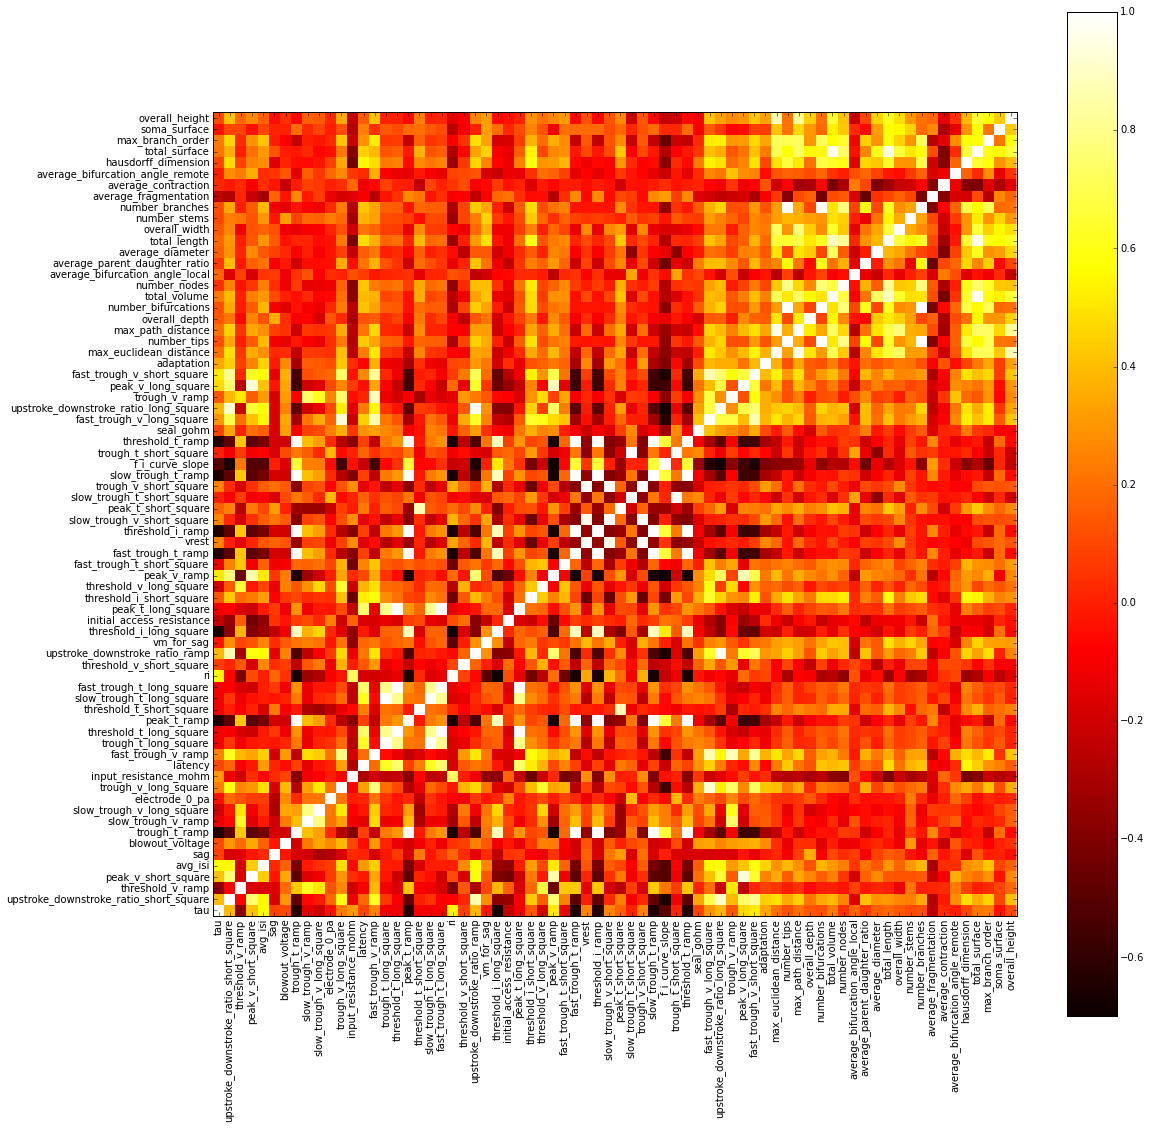

In [12]:
#Compute correlation of numerical features for cells that have both ephys and morphology data

corr = cell_data_num.corr()
fig, ax = plt.subplots(figsize=(18, 18))
img = ax.imshow(corr, interpolation='none', cmap = 'hot',origin = 'lower')

plt.xticks(range(len(corr.columns)), corr.columns,rotation=90);
plt.yticks(range(len(corr.columns)), corr.columns);
plt.colorbar(img)

#feature_corr = cell_data_num.corr()
#feature_corr.shape

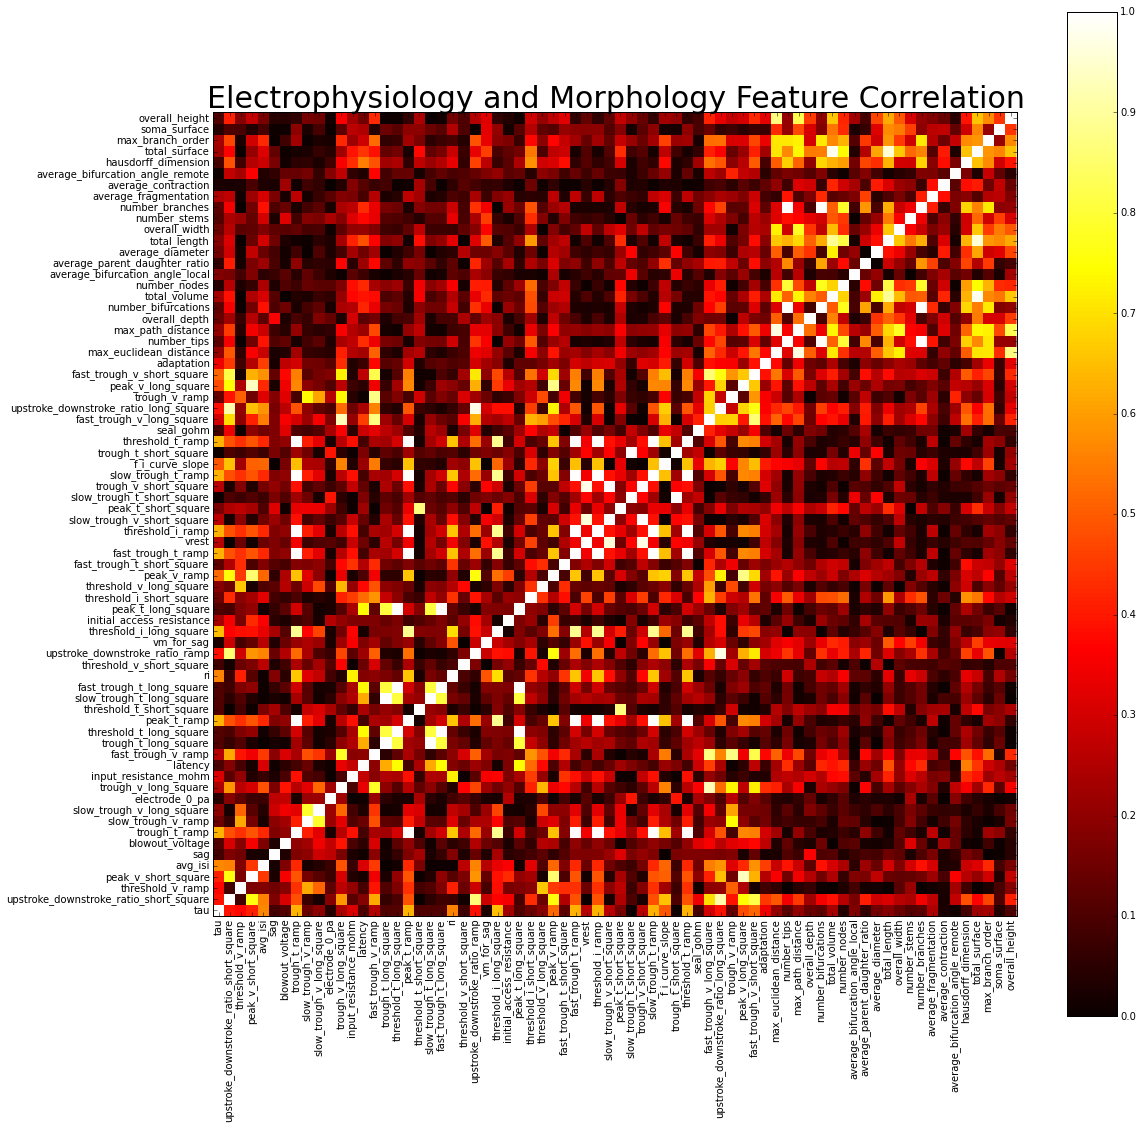

In [13]:
#Plot absolute values of correlations

corr_abs = corr.abs()

fig, ax = plt.subplots(figsize=(18, 18))
img = ax.imshow(corr_abs, interpolation='none', cmap = 'hot',origin = 'lower')

plt.xticks(range(len(corr_abs.columns)), corr_abs.columns,rotation=90);
plt.yticks(range(len(corr_abs.columns)), corr_abs.columns);
plt.colorbar(img)
plt.title('Electrophysiology and Morphology Feature Correlation',size=30)
plt.savefig('GiantCorr.png')


In [14]:
#Break correlation matrix into subsets
corr_abs_ephys = corr_abs.loc['tau':'adaptation','tau':'adaptation']
corr_abs_morph = corr_abs.loc['max_euclidean_distance':'overall_height','max_euclidean_distance':'overall_height']
corr_abs_ephysmorph = corr_abs.loc['max_euclidean_distance':'overall_height','tau':'adaptation']
corr_abs_ephysmorph.index

Index([u'max_euclidean_distance', u'number_tips', u'max_path_distance', u'overall_depth', u'number_bifurcations', u'total_volume', u'number_nodes', u'average_bifurcation_angle_local', u'average_parent_daughter_ratio', u'average_diameter', u'total_length', u'overall_width', u'number_stems', u'number_branches', u'average_fragmentation', u'average_contraction', u'average_bifurcation_angle_remote', u'hausdorff_dimension', u'total_surface', u'max_branch_order', u'soma_surface', u'overall_height'], dtype='object')

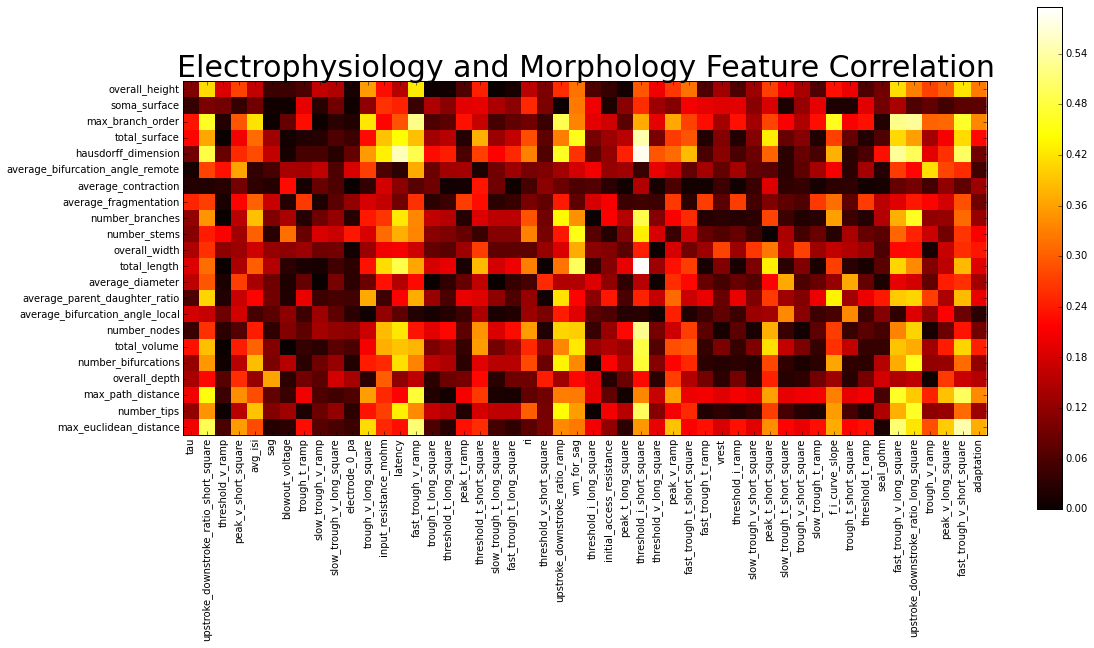

In [15]:
#Plot ephys vs morphology features

fig, ax = plt.subplots(figsize=(18, 9))
img = ax.imshow(corr_abs_ephysmorph, interpolation='none', cmap = 'hot',origin = 'lower')

plt.xticks(range(len(corr_abs_ephysmorph.columns)), corr_abs_ephysmorph.columns,rotation=90);
plt.yticks(range(len(corr_abs_ephysmorph.index)), corr_abs_ephysmorph.index);
plt.colorbar(img)
plt.title('Electrophysiology and Morphology Feature Correlation',size=30)
plt.savefig('EMCorr.png')

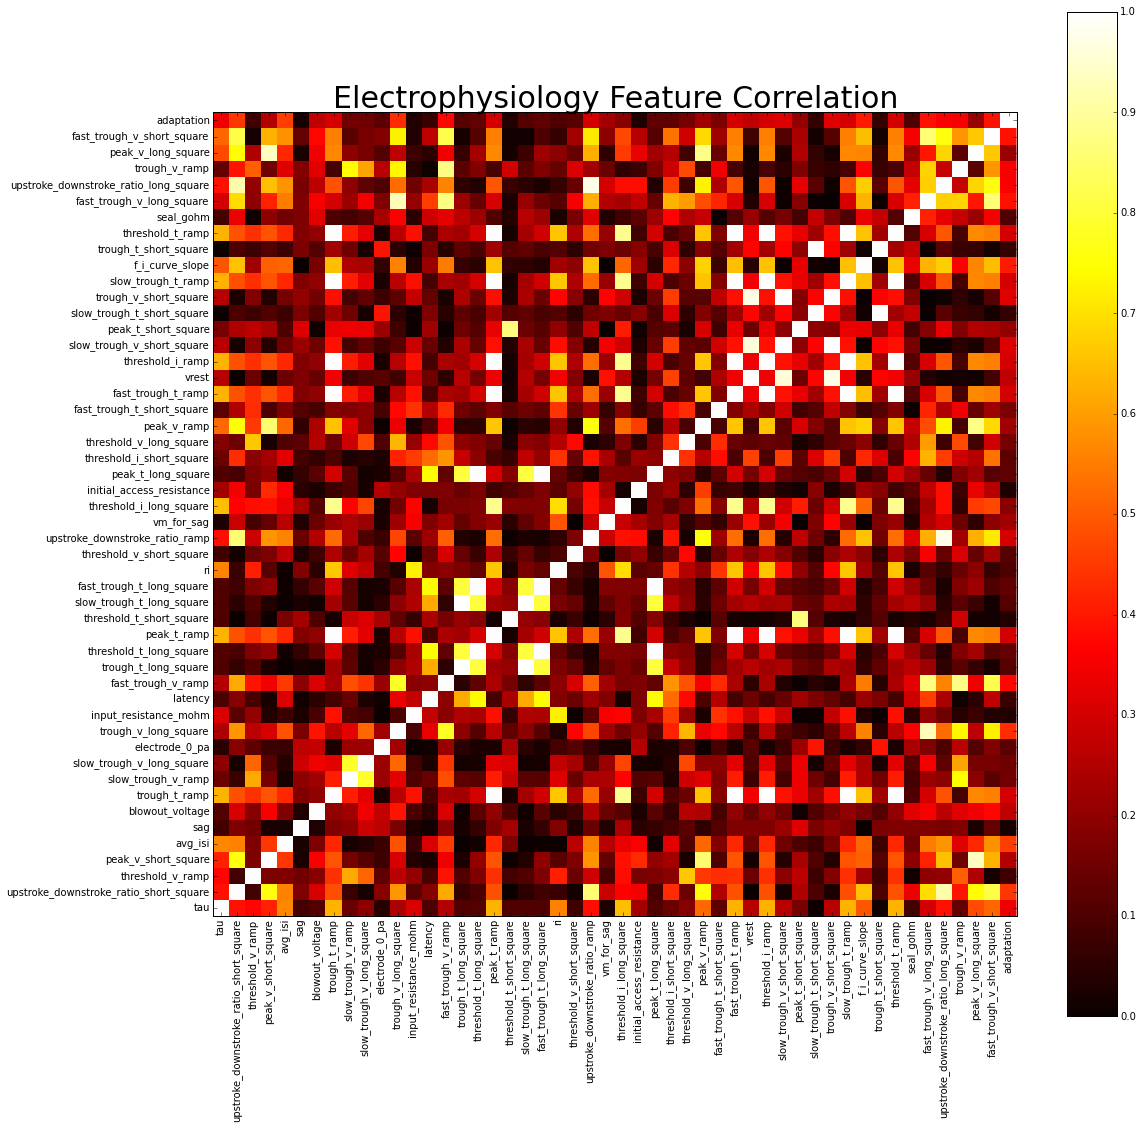

In [16]:
#Plot ephys vs ephys features

fig, ax = plt.subplots(figsize=(18, 18))
img = ax.imshow(corr_abs_ephys, interpolation='none', cmap = 'hot',origin = 'lower')

plt.xticks(range(len(corr_abs_ephys.columns)), corr_abs_ephys.columns,rotation=90);
plt.yticks(range(len(corr_abs_ephys.index)), corr_abs_ephys.index);
plt.colorbar(img)
plt.title('Electrophysiology Feature Correlation',size=30)
plt.savefig('ECorr.png')

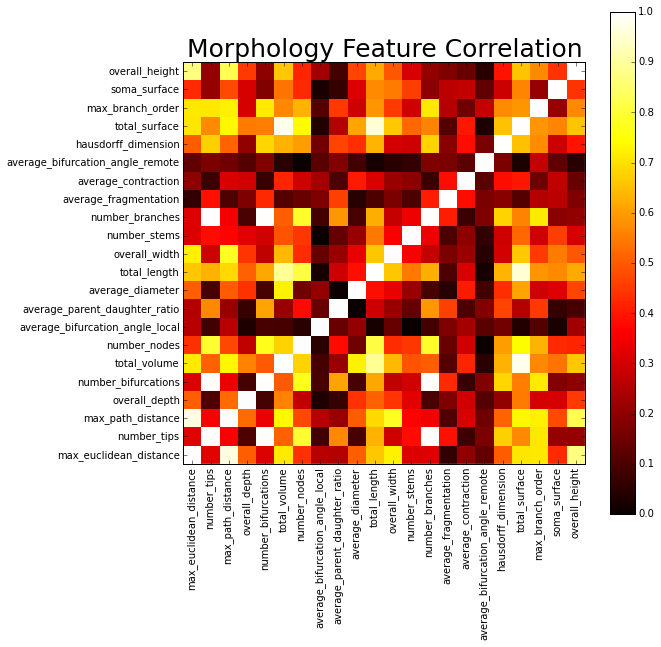

In [17]:
#Plot morphology vs morphology features

fig, ax = plt.subplots(figsize=(9, 9))
img = ax.imshow(corr_abs_morph, interpolation='none', cmap = 'hot',origin = 'lower')

plt.xticks(range(len(corr_abs_morph.columns)), corr_abs_morph.columns,rotation=90);
plt.yticks(range(len(corr_abs_morph.index)), corr_abs_morph.index);
plt.colorbar(img)
plt.title('Morphology Feature Correlation',size=25)
plt.savefig('MCorr.png')

In [196]:
#Choose type of comparison to analyze further
current_corr = corr_abs_ephysmorph

#Sort data by highest correlation value
s = current_corr.unstack()
so = s.order(kind="quicksort", ascending=False)

so2 = so[so <0.5]

so2

fast_trough_v_short_square              max_path_distance         0.498742
threshold_i_short_square                number_tips               0.498679
vm_for_sag                              total_length              0.497925
upstroke_downstroke_ratio_long_square   hausdorff_dimension       0.495464
upstroke_downstroke_ratio_short_square  max_euclidean_distance    0.493276
upstroke_downstroke_ratio_ramp          max_branch_order          0.491397
fast_trough_v_ramp                      hausdorff_dimension       0.488486
threshold_i_short_square                number_branches           0.488439
latency                                 total_length              0.486830
upstroke_downstroke_ratio_short_square  hausdorff_dimension       0.485484
threshold_i_short_square                total_volume              0.484436
                                        number_bifurcations       0.475597
fast_trough_v_ramp                      max_path_distance         0.475146
fast_trough_v_short_squar

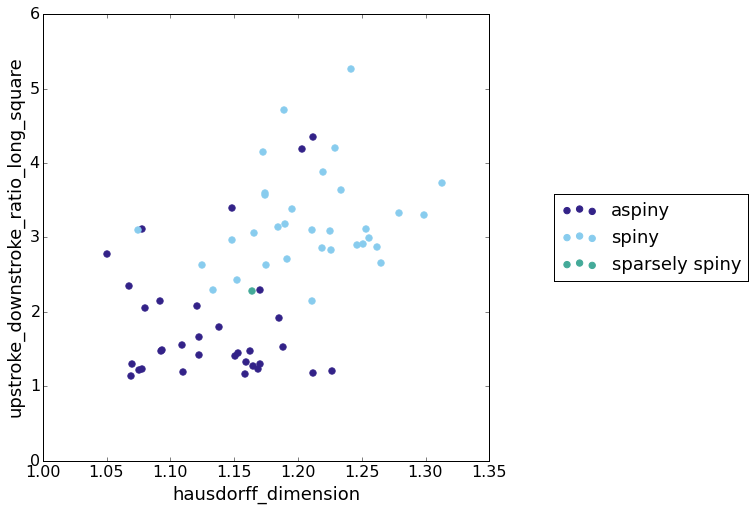

In [19]:
##Plotting individual feature comparisons to look at correlations in more detail.

#Define comparison to plot (one feature vs. another) to look at individual correlations. 
#Also choose type of grouping to use (e.g. color code by mouse line, dendrite type, etc).

#Choose one type of data class to color code by:['mouse_line','region','layer','hemisphere','dendrite_type'])
chosen_type = 'dendrite_type'
morph_feature = 'hausdorff_dimension'
ephys_feature = 'upstroke_downstroke_ratio_long_square'

type_list = set(cells_with_ephys_and_morph[chosen_type])
color_list = ["#332288","#88ccee","#44aa99","#117733","#999933","#ddcc77","#661100","#cc6677","#882255","#aa4499"]

cell_index = cells_with_ephys_and_morph.index

#Plot chosen data color coded by chosen type

fig, ax = plt.subplots(figsize=(8,8))
for a_type, color in zip(type_list, color_list[0:len(type_list)]): 
    #Tells you which rows have the chosen_type via True/False mask
    type_bool = cells_with_ephys_and_morph[cells_with_ephys_and_morph[chosen_type] == a_type]
    
    x_coords = type_bool[morph_feature]
    y_coords = type_bool[ephys_feature]
    ax.scatter(x_coords, y_coords, color=color, label=a_type,s=40)
lgd = ax.legend(loc='right',bbox_to_anchor=(1.6,0.5), prop={'size':18})
ax.set_xlabel(morph_feature,size=18)
ax.set_ylabel(ephys_feature,size=18)
ax.tick_params(axis='both', labelsize=16)

#Name and save file

file_name = ephys_feature + '_v_' + morph_feature + '_' + chosen_type + '.png'

fig.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')



In [122]:
##Set up SVM 

from sklearn import svm, preprocessing, cross_validation, grid_search, decomposition
from sklearn.svm import SVR,SVC
#Define scaler for data scaling to 0 mean and 1 variance below
scaler = preprocessing.StandardScaler()

#Create SVC object
#Defaults for class sklearn.svm.SVR are as follows
#(kernel='rbf', degree=3, gamma=0.0, coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)

clf = SVC()

#Define set of possible parameters for SVR optimization
c_vals = [.001, .01, .1, 1, 10, 100]
g_vals = [.001, .01, .1, 1, 10, 100]
kernels = ['rbf','linear','poly']
n_folds = 5

c_vals = c_vals[0:5]
g_vals = g_vals[0:5]

In [123]:
#features_to_predict = np.insert(cells_with_ephys_and_morph['dendrite_type'].reshape(-1,1),0,cells_with_ephys_and_morph['mouse_line'],1)
'''
features_to_predict = cells_with_ephys_and_morph['dendrite_type']
le = preprocessing.LabelEncoder()
le.fit(features_to_predict)
list(le.classes_)
class_numbers = le.transform(features_to_predict)
#list(le.inverse_transform([2, 2, 1]))
#list(le.inverse_transform(features_to_predict))
class_numbers[1]
'''

"\nfeatures_to_predict = cells_with_ephys_and_morph['dendrite_type']\nle = preprocessing.LabelEncoder()\nle.fit(features_to_predict)\nlist(le.classes_)\nclass_numbers = le.transform(features_to_predict)\n#list(le.inverse_transform([2, 2, 1]))\n#list(le.inverse_transform(features_to_predict))\nclass_numbers[1]\n"

In [211]:
cells_with_ephys_and_morph = cells_with_ephys_and_morph[cells_with_ephys_and_morph.dendrite_type != 'sparsely spiny']

#Loop over set of possible ephys or morphology features to predict. In the case of SVC, predict means classify.
features_to_predict = ['dendrite_type']
feature_data = cells_with_ephys_and_morph[features_to_predict]

#Change string values to numercial values to make SVC work.
le = preprocessing.LabelEncoder()
le.fit(feature_data)
#list(le.classes_)
class_numbers = le.transform(feature_data)

#n_features_to_predict = len(features_to_predict)
predictors = ['threshold_i_short_square','latency','fast_trough_v_long_square','fast_trough_v_short_square','upstroke_downstroke_ratio_long_square']
#                                       hausdorff_dimension       0.584700
#latency                                hausdorff_dimension       0.551187
#fast_trough_v_short_square             max_euclidean_distance    0.545290
#threshold_i_short_square               total_surface             0.544609
#fast_trough_v_long_square              hausdorff_dimension       0.534846
#upstroke_downstroke_ratio_long_square  max_branch_order          0.532876
#threshold_i_short_square               number_nodes              0.526376
#fast_trough_v_long_square              max_branch_order          0.523979
#fast_trough_v_ramp                     max_branch_order          0.523913
#fast_trough_v_long_square              max_euclidean_distance    0.513857
#fast_trough_v_ramp                     max_euclidean_distance    0.513618
#fast_trough_v_short_square             hausdorff_dimension       0.500501
#                                       max_path_distance         0.498742
#threshold_i_short_square    
              
#n_predictors = len(corr_abs_morph.index)
#number_predictors_to_test = n_predictors #Run full set overnight 
components = range(1,len(predictors)+1) #Numbers of PCA components to use in SVR
n_components = len(components)

#Scale/whiten predictors, center all on mean zero with Gaussian dist, variance 1
X_unscaled = cells_with_ephys_and_morph[predictors]
X_unscaled = X_unscaled.dropna().values

#Define feature matrix in which to place scores of model performance for each feature number
feature_scores = np.zeros(n_components)
#Define model parameters matrix in which to log parameters for each model run
#model_parameters_at_max = np.zeros(shape=3, n_components)

y_unscaled = class_numbers.ravel()
print y_unscaled
    
#Define parameter matrix in which to place scores
parameter_scores = np.empty(shape=(len(c_vals),len(kernels),len(g_vals), n_components))
parameter_scores[:]= np.nan

for c_number, c_val in enumerate(c_vals):
    for kernel_number, kernel in enumerate(kernels):
        for g_number, g_val in enumerate(g_vals):
            scores = [] #Rewrite scores variable each time through the loop
            kf = cross_validation.KFold(len(X_unscaled), n_folds=n_folds) #In this instance X and y end up different lengths after removing NaNs, y is shorter
            clf = SVC(C=c_val,gamma=g_val,kernel=kernel)
            for component in components: #For each number of components, run cross-validation
                for train_index, test_index in kf:
                    #Fit PCA based on predictors in training set, transform training and test sets
                   
                    #Loop over number of PCA components to use
                    X_train, X_test = X_unscaled[train_index, :], X_unscaled[test_index, :]
                    y_train, y_test = y_unscaled[train_index], y_unscaled[test_index]
                    
                    #Fit PCA based on predictors in training set, transform training and test sets
                    PCA_predictors = decomposition.PCA(n_components=component, whiten=True)
                    X_train_PCA = PCA_predictors.fit_transform(X_train) #PCA for predictors, so predictors become PCA components
                    X_test_PCA = PCA_predictors.transform(X_test) 
                    
                    #print PCA_predictors.components_, PCA_predictors.explained_variance_ratio_
                    #print features_to_predict, c_val, kernel, g_val, component, 
                    #Run SVR
                    clf.fit(X_train_PCA, y_train) 
                    
                    #Score SVR
                    scores.append(clf.score(X_test_PCA, y_test)) #Record each score for this set

                parameter_scores[c_number, kernel_number, g_number, component-1] = np.nanmean(scores)

feature_scores = parameter_scores.max(axis=(0, 1, 2)) #Max with respect to a particular axis, need to max across all 3?
#model_parameters_at_max[predicted_feature_number-1,:,component-1] = parameter_scores.argmax()
    
    #scores_matrix = ephys_feature + '_v_' + morph_feature + '_' + chosen_type + '.png'
#Save this score in a list for each feature set for this morphology feature


[0 1 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 0 1 0 1 0 0 0 0
 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 0 0 1 1 1 0 0 0 1]


C:\Users\Aiva\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


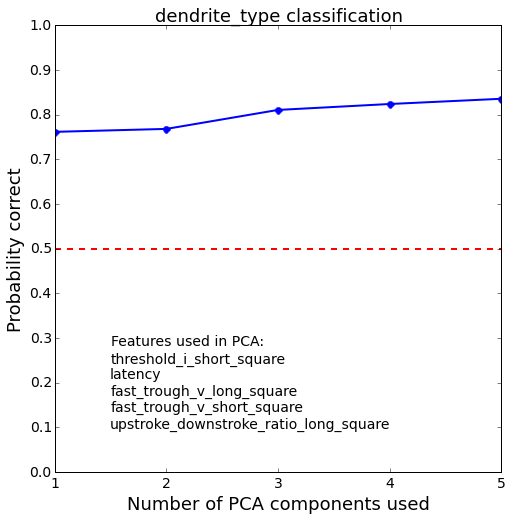

In [212]:
x_coords = components


fig, ax = plt.subplots(figsize=(8,8))
ax.plot(x_coords, feature_scores, label=a_type, linestyle='-', marker='.', markersize=14, lw=2)
ax.hlines(0.5, 1, len(predictors), linestyles='--', colors='r', lw=2)
title = features_to_predict[0] + ' classification'
ax.set_title(title, fontsize=18)

plt.text(1.5,0.1,'\n'.join(['Features used in PCA:'] + predictors), fontsize=14)

ax.set_ylim((0,1.0))
ax.locator_params(axis='y',nbins=10)
ax.locator_params(axis='x',nbins=n_components)
#Name and save file
file_name = title + 'classificationSVC_by_HausdorffCorrfeaturePCA_ephys' + str(len(predictors)) + '.png'

#ax.set_xlabel(ranked_feature_set[title],size=14) #Xlabels broken, but can figure out which features 
#correspond to which points by looking at ranked_feature_set and choosing first n values up to corresponding 
#x value on graph
ax.tick_params(axis='both', labelsize=14)

ax.set_ylabel('Probability correct',fontsize=18)
ax.set_xlabel('Number of PCA components used', fontsize=18)

fig.savefig(file_name)
    

In [133]:
predictors

['upstroke_downstroke_ratio_short_square',
 'upstroke_downstroke_ratio_long_square',
 'upstroke_downstroke_ratio_ramp',
 'fast_trough_t_short_square',
 'fast_trough_t_long_square',
 'fast_trough_t_ramp',
 'f_i_curve_slope']

In [171]:
file_name

'dendrite_type classificationclassificationSVC_by_AllenfeaturePCA_ephys6.png'

In [185]:
range(1,len(predictors)) 

[1, 2, 3, 4]